In [7]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cs231n-project/daniel/'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n-project/daniel


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tq
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('seaborn')

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float
print(f'device: {device}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device: cpu


In [ ]:
BATCH_SIZE = 64
NUM_TRAIN = 1250
NUM_TEST = 250

# C = number of classes = max(y_train) + 1
D, C = 8*8, 5

def load_dataset():
  X_train = np.load('./datasets/X_ImageNet_8x8_5c_train.npy')    # (6500, 8, 8)
  y_train = np.load('./datasets/y_ImageNet_8x8_5c_train.npy')    # (650, )
  X_test = np.load('./datasets/X_ImageNet_8x8_5c_test.npy')      # (250, 8, 8)
  y_test = np.load('./datasets/y_ImageNet_8x8_5c_test.npy')      # (250, )

  # Normalize
  mean, std = X_train.mean(), X_train.std()
  X_train = (X_train - mean) / std
  X_test = (X_test - mean) / std

  # y labels are numered from 1, we want them from zero
  y_train -= 1
  y_test -= 1

  X_train = X_train[:NUM_TRAIN]
  y_train = y_train[:NUM_TRAIN]
  X_test = X_test[:NUM_TEST]
  y_test = y_test[:NUM_TEST]

  print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
  print(f'X_test.shape: {X_test.shape}, y_train.shape: {y_test.shape}')

  return X_train, y_train, X_test, y_test

def get_datasets():
  X_train, y_train, X_test, y_test = load_dataset()
  X_train = torch.from_numpy(X_train).type(dtype)
  y_train = torch.from_numpy(y_train).long()
  X_test = torch.from_numpy(X_test).type(dtype)
  y_test = torch.from_numpy(y_test).long()
  train_dset = list(zip(X_train, y_train))
  test_dset = list(zip(X_test, y_test))
  return train_dset, test_dset

train_dset, test_dset = get_datasets()

def get_loaders():
  train_loader = DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=False)
  test_loader = DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False)
  return train_loader, test_loader

train_loader, test_loader = get_loaders()

X_train.shape: (1250, 8, 8), y_train.shape: (1250,)
X_test.shape: (250, 8, 8), y_train.shape: (250,)


In [ ]:
def check_accuracy(loader, model, loss_fn):  
    num_correct, num_samples = 0, 0
    model.eval()
    loss = 0.0
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(X).squeeze()
            loss += loss_fn(scores, y, model, scale_for_SGD=False)
            preds = scores.argmax(dim=1)
            # preds = (scores > 0.5).long()
            num_correct += (preds == y).sum()
            num_samples += preds.shape[0]
    acc = float(num_correct) / num_samples
    return acc, loss, num_correct, num_samples

def print_stats(iteration, loss, accuracy, num_correct, num_samples, dset):
  print('It: %d, %s | loss: %.3f, acc: %.2f%%, ratio: %d/%d' % (iteration, dset,  loss, 100 * accuracy, num_correct, num_samples))

def train(model, loss_fn, optimizer, train_loader, epochs, check_every, acc_check_loader_train, acc_check_loader_test, verbose):
  train_loss_history = []
  train_accuracy_history = []
  test_loss_history = []
  test_accuracy_history = []
  times = []
  start = time()
  done = False
  for e in tq.tqdm(range(epochs)):
    if done:
      break
    if verbose: 
      print(f'### Epoch {e} ###')
    for t, (X, y) in enumerate(train_loader):
      model.train()
      scores = model(X)

      # Forward pass
      loss = loss_fn(scores, y, model, scale_for_SGD=True)
      
      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if check_every is not None and (e*epochs + t) % check_every == 0:
        train_accuracy, train_loss, train_num_correct, train_num_samples = check_accuracy(acc_check_loader_train, model, loss_fn)
        test_accuracy, test_loss, test_num_correct, test_num_samples = check_accuracy(acc_check_loader_test, model, loss_fn)
        times.append(time() - start)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)
        if verbose:
          print_stats((e*epochs + t), train_loss, train_accuracy, train_num_correct, train_num_samples, 'train')
          print_stats((e*epochs + t), test_loss, test_accuracy, test_num_correct, test_num_samples, 'test')
        if train_accuracy == 1.0:
          done = True
          break
  
  return train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history, times

In [ ]:
class Polly(nn.Module):
  def forward(self, x):
    return (0.09 * x**2 + 0.5 * x + 0.47)

class LinearUnitNorm(nn.Module):
  def __init__(self, D, H):
    super(LinearUnitNorm, self).__init__()
    self.W = torch.nn.Parameter(data=torch.normal(mean=0, std=1, size=(D, H), dtype=dtype))
    nn.init.kaiming_normal_(self.W)

  def forward(self, x):
    return x @ (self.W / torch.linalg.norm(self.W, dim=0, keepdim=True))

H = 434
beta = 1

model = nn.Sequential(
  nn.Flatten(),
  LinearUnitNorm(D, H),
  Polly(),
  nn.Linear(H, C, bias=False)
)

def loss_fn(scores, y, model, scale_for_SGD):
  N, C = scores.shape
  Y = torch.zeros((N, C))
  Y[range(N), y] = 1
  W2 = model[3].weight
  if scale_for_SGD:
    loss = 0.5*((scores - Y)**2).sum() * NUM_TRAIN/N + beta * torch.abs(W2).sum()
  else:
    loss = 0.5*((scores - Y)**2).sum() + beta * torch.abs(W2).sum() * N/NUM_TRAIN
  return loss


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history, times = train(
    model, loss_fn, optimizer, train_loader, epochs=4000,
    check_every=100, acc_check_loader_train=train_loader, acc_check_loader_test=test_loader, verbose=False,
)


In [5]:
filename = 'FC_ImageNet_NonConvex'
lr = 1e-3
epochs = 3000

def save_data():
  np.save(f'./experiments/{filename}_{"Adam"}_lr_{lr}_epochs_{epochs}_{"training"}_{"loss_history"}.npy', train_loss_history)
  np.save(f'./experiments/{filename}_{"Adam"}_lr_{lr}_epochs_{epochs}_{"training"}_{"accuracy_history"}.npy', train_accuracy_history)
  np.save(f'./experiments/{filename}_{"Adam"}_lr_{lr}_epochs_{epochs}_{"test"}_{"loss_history"}.npy', test_loss_history)
  np.save(f'./experiments/{filename}_{"Adam"}_lr_{lr}_epochs_{epochs}_{"test"}_{"accuracy_history"}.npy', test_accuracy_history)
  np.save(f'./experiments/{filename}_{"Adam"}_lr_{lr}_epochs_{epochs}_{""}_{"times"}.npy', times)

# save_data()

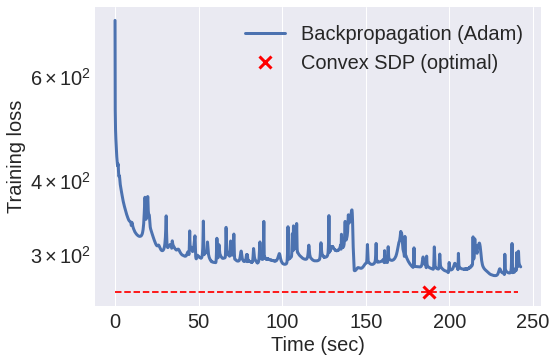

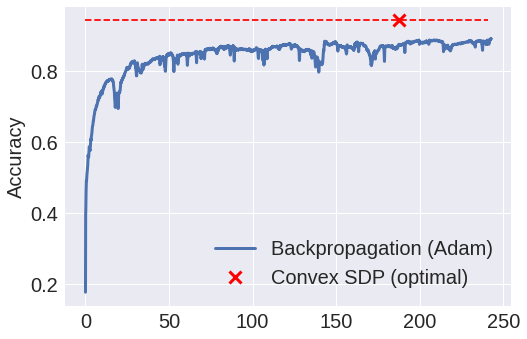

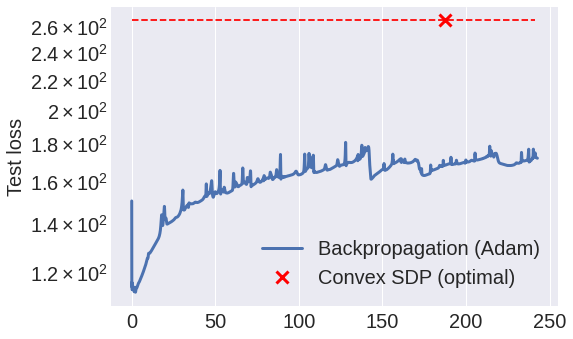

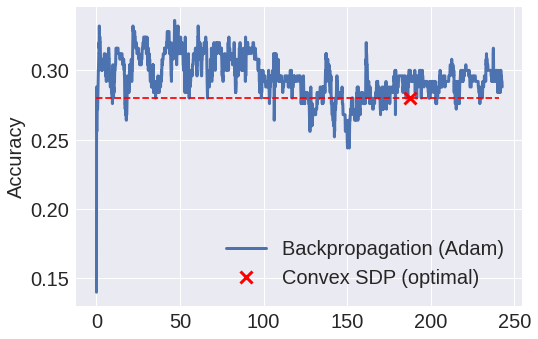

In [10]:
train_loss_history = np.load(f'./experiments/{filename}_{"Adam"}_lr_{lr}_epochs_{epochs}_{"training"}_{"loss_history"}.npy')
train_accuracy_history = np.load(f'./experiments/{filename}_{"Adam"}_lr_{lr}_epochs_{epochs}_{"training"}_{"accuracy_history"}.npy')
test_loss_history = np.load(f'./experiments/{filename}_{"Adam"}_lr_{lr}_epochs_{epochs}_{"test"}_{"loss_history"}.npy')
test_accuracy_history = np.load(f'./experiments/{filename}_{"Adam"}_lr_{lr}_epochs_{epochs}_{"test"}_{"accuracy_history"}.npy')
times = np.load(f'./experiments/{filename}_{"Adam"}_lr_{lr}_epochs_{epochs}_{""}_{"times"}.npy')


convex_train_loss = 258.8
convex_train_accuracy = 0.9424
convex_time = 187.7
convex_test_loss = 265.38
convex_test_accuracy = 0.28

max_timerange = int(max(max(times), convex_time))
timerange = list(range(max_timerange))

plt.rcParams.update({'font.size': 40})
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.xlabel('Time (sec)')

plt.semilogy(times, train_loss_history, linewidth=3, label='Backpropagation (Adam)')
plt.ylabel(r'Training loss')
plt.plot(timerange,[convex_train_loss]*max_timerange, "--", color='r')
plt.plot(convex_time, convex_train_loss, 'rx', linewidth=3, markersize=12, markeredgewidth=3, label="Convex SDP (optimal)")
plt.legend()
plt.savefig(f'./plots/{filename}_{"training"}_{"loss"}')
plt.show()

plt.plot(times, train_accuracy_history, linewidth=3, label='Backpropagation (Adam)')
plt.ylabel('Accuracy')
plt.plot(timerange,[convex_train_accuracy]*max_timerange, "--", color='r')
plt.plot(convex_time, convex_train_accuracy, 'rx', linewidth=3, markersize=12, markeredgewidth=3, label="Convex SDP (optimal)")
plt.legend()
plt.savefig(f'./plots/{filename}_{"training"}_{"accuracy"}')
plt.show()

plt.semilogy(times, test_loss_history, linewidth=3, label='Backpropagation (Adam)')
plt.ylabel(r'Test loss')
plt.plot(timerange,[convex_test_loss]*max_timerange, "--", color='r')
plt.plot(convex_time, convex_test_loss, 'rx', linewidth=3, markersize=12, markeredgewidth=3, label="Convex SDP (optimal)")
plt.legend()
plt.savefig(f'./plots/{filename}_{"test"}_{"loss"}')
plt.show()

plt.plot(times, test_accuracy_history, linewidth=3, label='Backpropagation (Adam)')
plt.ylabel('Accuracy')
plt.plot(timerange,[convex_test_accuracy]*max_timerange, "--", color='r')
plt.plot(convex_time, convex_test_accuracy, 'rx', linewidth=3, markersize=12, markeredgewidth=3, label="Convex SDP (optimal)")
plt.legend()
plt.savefig(f'./plots/{filename}_{"test"}_{"accuracy"}')
plt.show()